# Retino-cortical map

We need to define the retino-cortical map that maps retinal coordinates to the primary visual cortex V1 (see Tamekue et al. (2022) and references therein).

## Point types

We start by defining the type of points we will use. 

In [1]:
# Standard cartesian coordinates in the retinal plane
struct CartesianPoint{T<:Real}
    x::T
    y::T
end

CartesianPoint(x::Real, y::Real) = CartesianPoint(promote(x,y)...)

x(p::CartesianPoint) = p.x
y(p::CartesianPoint) = p.y

y (generic function with 1 method)

Coordinates on the visual field (or in the retina) are polar coordinates $(r,\theta)\in[0,\infty)\times[0,2\pi)$ from the fovea.

In [2]:
# Polar coordinates in the retinal plane
struct RetinalPoint{T<:Real} 
    r::T
    θ::T
end

RetinalPoint(r::Real, θ::Real) = RetinalPoint(promote(r,θ)...)

r(p::RetinalPoint) = p.r
θ(p::RetinalPoint) = p.θ

# Conversions cartesian <-> polar
Base.convert(::Type{RetinalPoint}, p::CartesianPoint; args...) = 
    RetinalPoint( sqrt( x(p)^2 + y(p)^2 ), atan(y(p), x(p)) )
Base.convert(::Type{CartesianPoint}, p::RetinalPoint; args...) = 
    CartesianPoint( r(p)*cos(θ(p)) , r(p)*sin(θ(p)) )

Coordinates on V1 are standard Cartesian coordinates $(x_1,x_2)\in\mathbb{R}^2$.

In [3]:
# Coordinates in the cortical plane
struct CorticalPoint{T<:Real} 
    x::T
    y::T
end

CorticalPoint(x::Real, y::Real) = CorticalPoint(promote(x,y)...)
x(p::CorticalPoint) = p.x
y(p::CorticalPoint) = p.y

y (generic function with 2 methods)

## Conversion formulas

The retino-cortical map (see, e.g., Tamekue et al. (2022) and references within) is given by 
\begin{equation*}
	r e^{i\theta}  \mapsto (x_1,x_2):=\left( \log r, \theta \right).
\end{equation*}

In [4]:
# retinal to cortical
Base.convert(::Type{CorticalPoint}, p::RetinalPoint; far_from_fovea = false) = 
            far_from_fovea ?  CorticalPoint(log(1+ r(p)) , (r(p)*θ(p))/(1+r(p))) : CorticalPoint(log(r(p)) , θ(p))

# cortical to retinal
function Base.convert(::Type{RetinalPoint}, p::CorticalPoint{T}; far_from_fovea = false) where T<:Real
    if iszero( x(p) )
        return RetinalPoint{T}(0,0)
    end
    r = far_from_fovea ?  exp(x(p))-1 : exp(x(p))
    far_from_fovea ? RetinalPoint( r , y(p)*( 1 + 1/r) ) : RetinalPoint( r , y(p))
end

# cartesian <-> cortical conversions
Base.convert(::Type{CorticalPoint}, p::CartesianPoint; args...) = 
            convert(CorticalPoint, convert(RetinalPoint, p; args...); args...)
Base.convert(::Type{CartesianPoint}, p::CorticalPoint; args...) = 
            convert(CartesianPoint, convert(RetinalPoint, p; args...))

## Converting an image from retinal to cortical and conversely

We will represent an image in the retinal plane as a function in the square $[-10,10]\times [-1,1]$. Let's find out to what part of the cortical plane this square corresponds:

In [5]:
a = zeros(200,200)

mesh(img) = [ CartesianPoint(x,y) for x in range(-10,10, length = size(img, 1)), y in range(-10,10, length = size(img, 2))]

x.(convert.(CorticalPoint, mesh(a))) |> extrema |> display
y.(convert.(CorticalPoint, mesh(a))) |> extrema |> display


# We should adjust the intervals for the inverse map (cort2res)
x.(convert.(CorticalPoint, mesh(a), far_from_fovea = true)) |> extrema |> display
y.(convert.(CorticalPoint, mesh(a), far_from_fovea = true)) |> extrema |> display

(-2.644146141450474, 2.649158683274018)

(-3.136567570258981, 3.136567570258981)

(0.06865442183481746, 2.7174812964321107)

(-2.8514283367165345, 2.8514283367165345)

We then define the functions to convert images from their retinal to their cortical representations.

In [6]:
using Images, ImageShow
using Interpolations

function fovea(img)
    xs = range(-1,1, length = size(img, 1))
    ys = range(-1,1, length = size(img, 2))
    eltype(img)[ xs[i]^2+ys[j]^2 < 1 ? img[i,j] : 1. for i in 1:length(xs), j in 1:length(ys)  ]
end

function res2cort(img; far_from_fovea = false)
    # Linear interpolation of starting image
    xs = range(-10,10, length = size(img, 1))
    ys = range(-10,10, length = size(img, 2))
    interp_linear = LinearInterpolation((xs, ys), transpose(convert.(Float64, img)), extrapolation_bc = Line())

    res = similar(img, Gray)
    xs = far_from_fovea ?  range(0.068, 2.717, length = size(img,1)) : range(-2.644, 2.649, length = size(img,1))
#    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-2.851, 2.851, length = size(img,2))
    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-3.136, 3.136, length = size(img,2))
    for i in 1:size(img,2), j in 1:size(img,1)
        p = convert(CartesianPoint, CorticalPoint(xs[i], ys[j]), far_from_fovea = far_from_fovea)
        res[j,i] =  convert(Gray, interp_linear(x(p), y(p)))
    end
    
    res
end

function cort2res(img; far_from_fovea = false)
    # Linear interpolation of starting image
    xs = far_from_fovea ?  range(0.068, 2.717, length = size(img,1)) : range(-2.644, 2.649, length = size(img,1))
    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-3.136, 3.136, length = size(img,2))
    interp_linear = LinearInterpolation((xs, ys), transpose(convert.(Float64, img)), extrapolation_bc = Line())

    res = similar(img, Gray)
    xs = range(-10,10, length = size(img, 1))
    ys = range(-10,10, length = size(img, 2))
    for i in 1:size(img,2), j in 1:size(img,1)
        p = convert(CorticalPoint, CartesianPoint(xs[i], ys[j]), far_from_fovea = far_from_fovea)
        res[j,i] =  convert(Gray, interp_linear(x(p), y(p)))
    end
    
    res
end

cort2res (generic function with 1 method)

# Finding the stationary state of NF equation

The theory tells us that, given an input $I$, the corresponding stationary state is $\Psi(I)$ that solves the following equation:
$$
\Psi(I)(x) = \mu\int w_2(x,y)f(\Psi(I)(y))\,dy +I(x),\qquad x\in\mathbb R^2.
$$
We then code an iterative procedure (which converges thanks to the fixed point theorem) to derive $\Psi(I)$.

### We start by defining the parameters for the model.

In [7]:
using Plots, LaTeXStrings

##################################
# Billock and Tsou's experiments #
##################################


σ_1      = 0.1
σ_2      = 0.5
κ        = (σ_1/σ_2)^2*exp(2*pi^2*(σ_2^2-σ_1^2))
ω(x,y)   = (1/(2π*σ_1^2))*exp(-(x^2+y^2)/(2*σ_1^2))-κ*(1/(2π*σ_2^2))*exp(-(x^2+y^2)/(2*σ_2^2))
ω_1(r)   = exp(-2*pi^2*σ_1^2*r^2)-κ*exp(-2*pi^2*σ_2^2*r^2)                 #Fourier transform of ω
q_c      = sqrt(log(κ*σ_2^2/σ_1^2)/(2π^2*(σ_2^2-σ_1^2)))                   #wavenumber
Θ        = σ_1*σ_2*sqrt(2*log(σ_2^2/(κ*σ_1^2))/(σ_2^2-σ_1^2))
C_1      = (1-κ)+2*(κ*exp(-0.5*Θ^2/σ_2^2)-exp(-0.5*Θ^2/σ_1^2))         #L^1-norm of ω
μ_0      = 1/C_1
μ_c      = 1/ω_1(q_c)                                                  #bifurcation point
μ        = 0.99*μ_0

#################
# MacKay effect #
#################

# Uncomment for MacKay effect simulations

#ω(x,y)   = π*exp(-π^2*(x^2+y^2))-π*exp(-π^2*(x^2+y^2)/2)/2 
#ω_1(r)   = exp(-r^2)-exp(-2*r^2)                            #Fourier transform of ω
#q_c      = sqrt(log(2))                                     #wavenumber
#μ_0      = 2
#μ_c      = 1/ω_1(q_c)                                       #bifurcation point
#μ        = 0.5*μ_0

0.21518283891839976

# Stationary state

Definition of the convolution operator $K(a) = \omega\ast a$.

In [8]:
using OffsetArrays, ImageFiltering

As(Δx; L=10) = centered([Δx^2*ω(x,y) for x in -L:Δx:L, y in -L:Δx:L])

function K(a, As)
    imfilter(a,reflect(As),"reflect")
end

K (generic function with 1 method)

Fixed point routine.

In [9]:
using Distances
function Ψ(I; Δx = .01, max_iter = 100, threshold = 1e-11)
    # As first step we take I
    prec = I
    ΨI = I
    # to keep track of final iteration
    final_iter = max_iter
    for i in 1:max_iter
        ΨI = μ*K(σ.(ΨI), As(Δx)) + I
        evaluate(Chebyshev(), prec, ΨI)
        if Chebyshev()(prec, ΨI) <= threshold
            final_iter = i
        break
        else
            prec = ΨI
        end
    end
    println("Extrema of I: ", extrema(I), ", extrema of ΨI: ", extrema(ΨI))
    a        = [I[i,j]>0 ? 0. : 1. for i in 1:size(I,1), j in 1:size(I,1)]
    b        = [ΨI[i,j]>0 ? 0. : 1. for i in 1:size(ΨI,1), j in 1:size(ΨI,1)]
    A        = Gray.(rotl90(a)) 
    B        = Gray.(rotl90(b))
    A_1      = cort2res(A)
    B_1      = cort2res(B)
   hcat(A_1, ones(Gray, (size(A_1,1),50)), B_1)
end

Ψ (generic function with 1 method)

# Reproducing the MacKay effect

## MacKay effect with linear response function

Here, we show that the MacKay effect can be reproduced with a linear response function $\sigma(s)=s$.

In the left we have the external input in the retina and on the right the illusory after-image perceived.

Extrema of I: (-1.0, 1.025), extrema of ΨI: (-1.0727619511649253, 1.0869082992439065)
398.825579 seconds (8.43 G allocations: 268.163 GiB, 7.71% gc time, 0.47% compilation time)


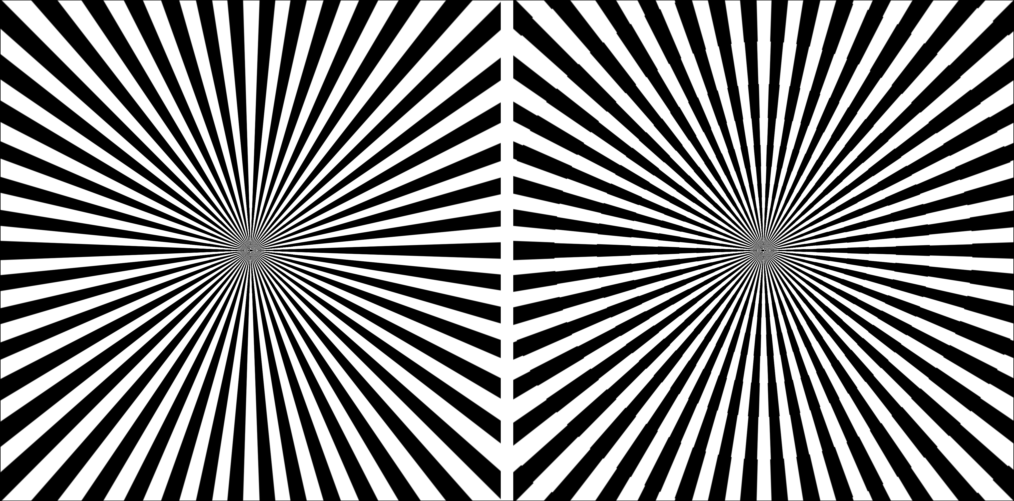

In [10]:
# MacKay effect for funnel pattern (``MacKay rays'')
Δx       = .01
L        = 10
λ        = 5π
f(x,y)   = cos(λ*y)
χ(x,y)   = (-L ≤ x ≤ 2) && (-L ≤ y ≤ L) ? 0.025 : 0.
v(x,y)   = f(x,y)+χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]

#the response function is linear
σ(s)     = s                    

@time res1 = Ψ(I, Δx=Δx,threshold = 1e-15)

Extrema of I: (-1.0, 1.025), extrema of ΨI: (-1.0719474281850094, 1.09011484423502)
1420.739377 seconds (6.75 G allocations: 214.456 GiB, 2.35% gc time, 0.01% compilation time: 99% of which was recompilation)


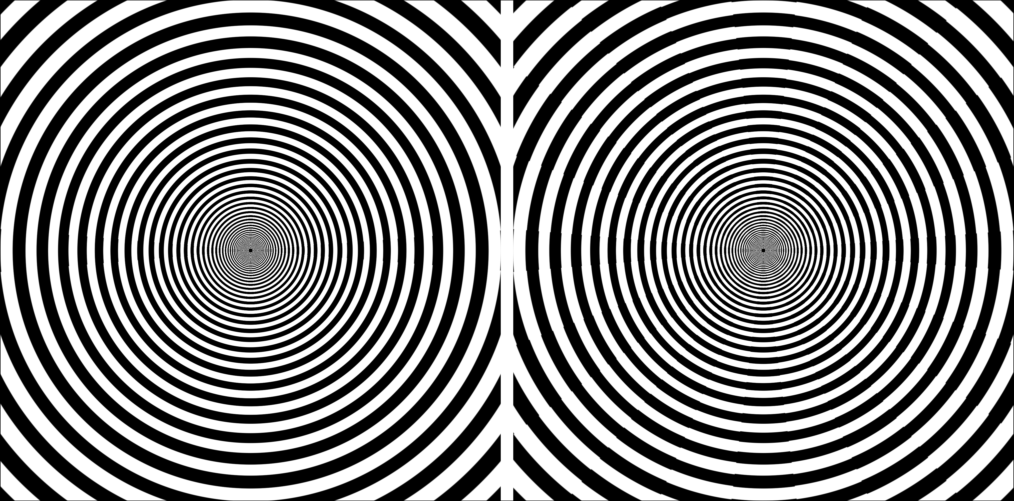

In [11]:
# MacKay effect for tunnel pattern

Δx       = .01
L        = 10
λ        = 5π
f(x,y)   = cos(λ*x)
χ(x,y) = (-L ≤ x ≤ L) && ((-.25 ≤ y ≤ .25) || (9.75 ≤ y ≤ L) || (-L ≤ y ≤ -9.75)) ? 0.025 : 0.
v(x,y)   = f(x,y)+χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]

#the response function is linear
σ(r)     = r                    

@time  Ψ(I, Δx=Δx,threshold = 1e-12)

## MacKay effect with nonlinear response function

With a nonlinear response function which is sigmoidal and odd, the equation reproduces the MacKay effect. Namely, we consider the choices
$$
\sigma(s) = \frac{s}{1+|s|} \quad\text{and}\quad \sigma(s) = \tanh(s).
$$

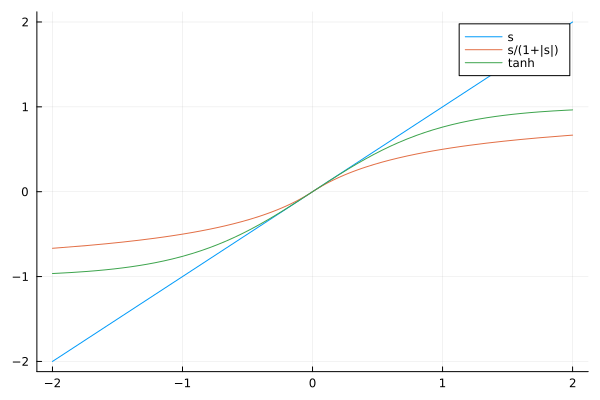

In [12]:
plot([s->s, s->s/(1+abs(s)), tanh], -2,2, labels = ["s" "s/(1+|s|)" "tanh"])

In the left we have the external input in the retina and on the right the illusory after-image perceived.

Extrema of I: (-1.0, 1.1), extrema of ΨI: (-1.0473392001256758, 1.1230694103912728)
118.580268 seconds (2.46 G allocations: 78.160 GiB, 8.76% gc time, 0.01% compilation time: 100% of which was recompilation)


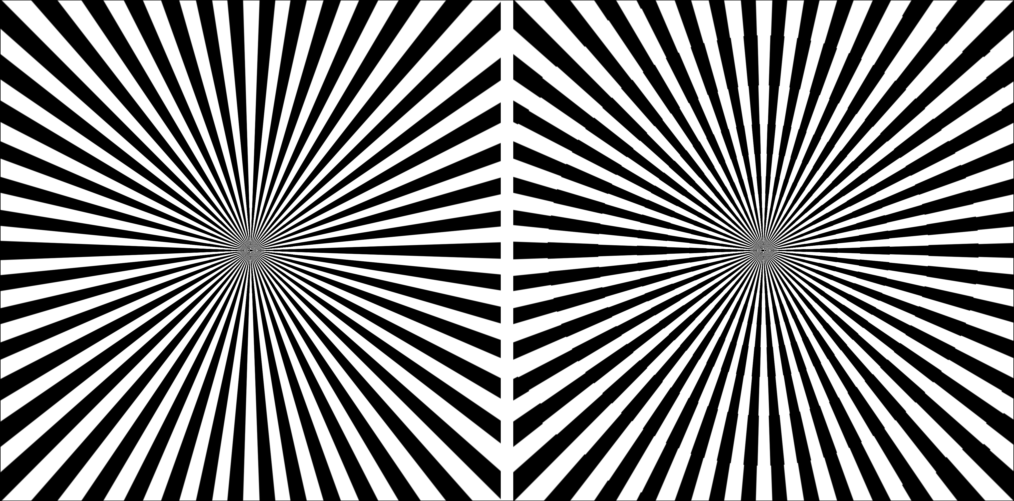

In [13]:
# The MacKay effect for funnel pattern (``MacKay rays'')
Δx       = .01
L        = 10
λ        = 5π
f(x,y)   = cos(λ*y)
χ(x,y)   = (-L ≤ x ≤ 2) && (-L ≤ y ≤ L) ? 0.1 : 0.
v(x,y)   = f(x,y)+χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]

#the response function is nonlinear
σ(s)     = s/(1+abs(s))

@time res1 = Ψ(I, Δx=Δx,threshold = 1e-15)

Extrema of I: (-1.0, 1.025), extrema of ΨI: (-1.0560850066753205, 1.075953895049945)
140.653223 seconds (2.62 G allocations: 83.502 GiB, 10.28% gc time, 0.01% compilation time: 100% of which was recompilation)


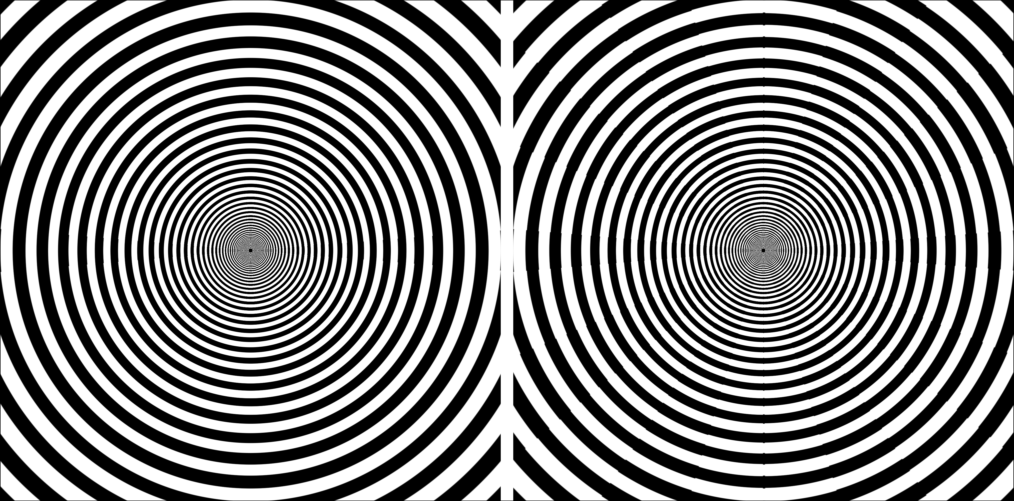

In [14]:
# The MacKay effect for tunnel pattern

Δx       = .01
L        = 10
λ        = 5π
f(x,y)   = cos(λ*x)
χ(x,y) = (-L ≤ x ≤ L) && ((-.25 ≤ y ≤ .25) || (9.75 ≤ y ≤ L) || (-L ≤ y ≤ -9.75)) ? 0.025 : 0.
v(x,y)   = f(x,y)+χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]

#the response function is nonlinear
σ(s)     = tanh(s)

@time  Ψ(I, Δx=Δx,threshold = 1e-12)

# Reproducing Billock and Tsou's phenomena

For Billok and Tsou's phenomenon we consider the family of response functions
$$\sigma(s) = \max(-m, \min(1, \alpha*s)).$$

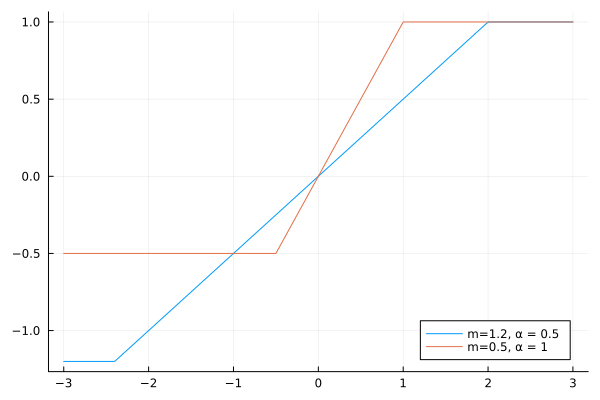

In [15]:
σ(s; m = 1, α = 1) = max( -m, min( 1, α*s) )

plot([ s->σ(s, m= 1.2, α = .5), s->σ(s, m= .5, α = 1) ], -3, 3, 
    labels = [ "m=1.2, α = 0.5" "m=0.5, α = 1"], legend = :bottomright )

In the left we have the external input in the retina and on the right the illusory after-image perceived.

Extrema of I: (-1.0, 1.0), extrema of ΨI: (-1.2172661417138708, 0.9933121217784716)


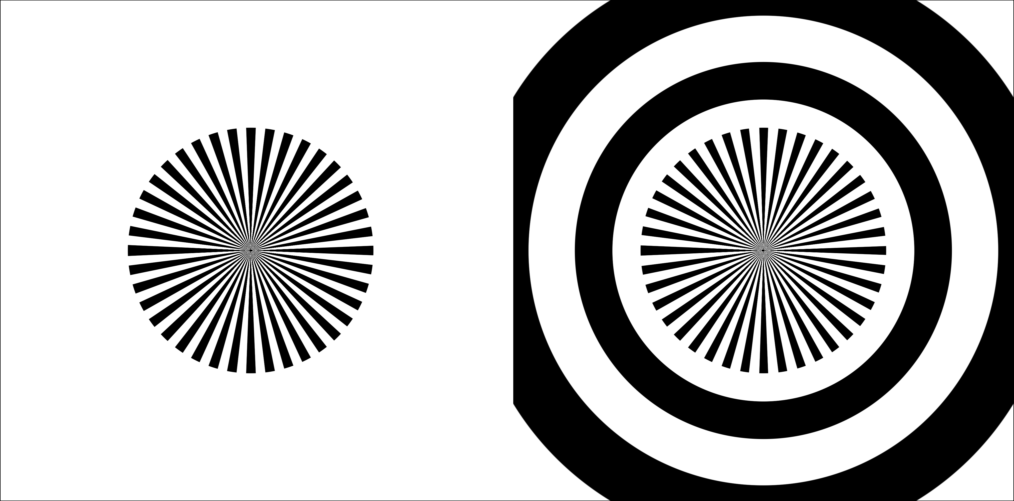

In [16]:
# Billock and Tsou's experiments for funnel pattern localised at the fovea
Δx       = .01
L        = 10
λ        = 4π
f(x,y)   = cos(λ*y)               # funnel pattern
χ(x,y)   = (-L ≤ x ≤ 6) && (-L ≤ y ≤ L) ? 1 : 0.    #localised function
v(x,y)   = f(x,y)*χ(x,y)                          
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L] #external input for funnel pattern localised at the fovea


# response function (m = 0.2, α = 1.2)
σ(r)     = max(-0.2,min(1,1.2*r)) 

Ψ(I, Δx=Δx,threshold = 1e-11)

Extrema of I: (-1.0, 1.0), extrema of ΨI: (-1.1033525614458126, 1.1105164315311402)


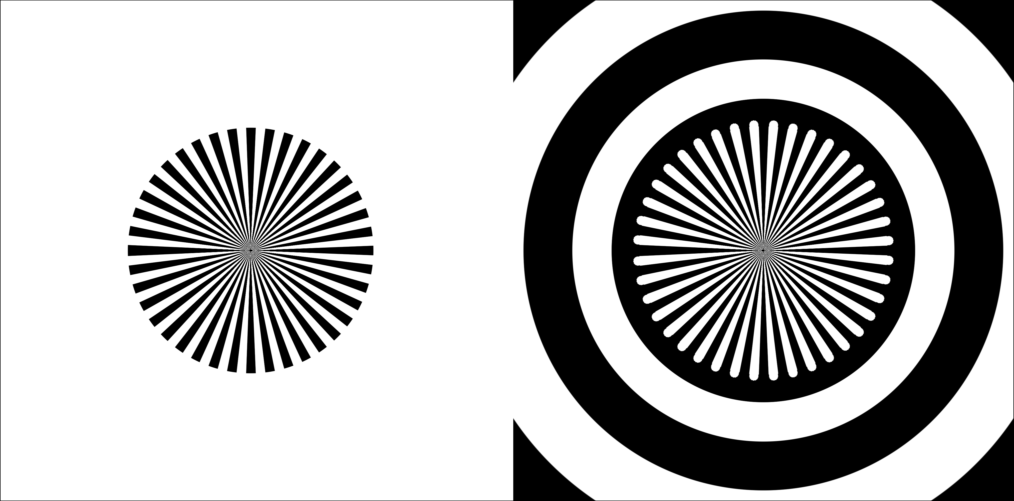

In [17]:
# Billock and Tsou's experiments for funnel pattern localised at the fovea
Δx       = .01
L        = 10
λ        = 4π
f(x,y)   = cos(λ*y)                                 # funnel pattern
χ(x,y)   = (-L ≤ x ≤ 6) && (-L ≤ y ≤ L) ? 1 : 0.  #localised function
v(x,y)   = f(x,y)*χ(x,y)                         
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L] #external input for funnel pattern localised at the fovea

# response function (m = 0.2, α = 1)
σ(r)     = max(-1.2,min(1,r))

Ψ(I, Δx=Δx,threshold = 1e-11)

Extrema of I: (-2.0, 2.0), extrema of ΨI: (-2.268677615677202, 1.9730757470108315)


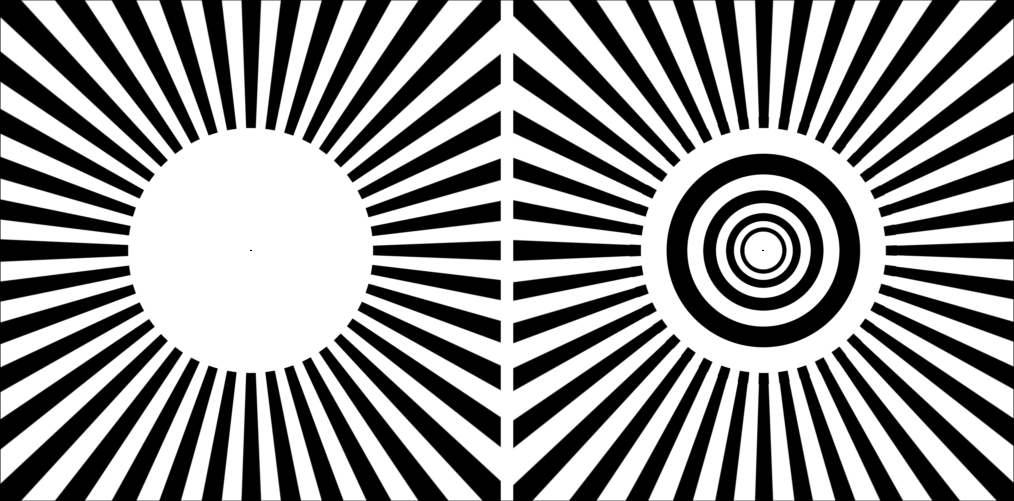

In [18]:
# Billock and Tsou's experiments for funnel pattern localised in the periphery
Δx       = .01
L        = 10
λ        = 4π
f(x,y)   = cos(λ*y)                                    # funnel pattern
χ(x,y)   = (6 ≤ x ≤ L) && (-L ≤ y ≤ L) ? 2 : 0.        #localised function  
v(x,y)   = f(x,y)*χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]     #external input for funnel pattern localised in the periphery

# response function (m = 0.2, α = 0.8)
σ(r)     = max(-0.2,min(1,0.8*r))

Ψ(I, Δx=Δx,threshold = 1e-11)

## Relation between response function parameters and reproducibility of Billock and Tsou phenomena

A theorem provided in the theoretical work tells us that phenomena reported by Billock and Tsou are wholly nonlinear. It means, the NF equation with a linear response function $\sigma$ do not reproduce the phenomena. 

As before, we take 
$$\sigma(s) = \max(-m, \min(1, \alpha*s)),\qquad s\in\mathbb R,$$
where $m\ge 0$ and $\alpha>0$. We then provide a range of parameters $(m, \alpha)$ where the sigmoid $f$ reproduces the phenomena or not:

1) The region where the couple $(m,\alpha)$ reproduces the phenomena is magenta;

2) The region where the couple $(m,\alpha)$ reproduces the phenomena and the stimulus extends through the surround is yellow;

3) The region where the couple $(m,\alpha)$ do not reproduce the phenomena is black.

In [19]:
function BillockTsouTests(I, m::Vector, n::Vector; Δx = .01, max_iter = 100, threshold = 1e-11)
    S_1      = zeros(length(m), length(n))                 # Storage matrix
    compteur = 0                                           # to verify that the stimulus does not extends through the complementary region

    for i in 1:length(m), j in 1:length(n)
        σ(r)        = max(-m[i],min(1,n[j]*r))
        println("\n minimal bound of the saturation : m  = ", m[i], ", slope of the saturation : α = ", n[j])
        mat         = Ψ(I, Δx=Δx,threshold = threshold);
        a1          = mat[1:size(mat,1),1602:size(mat,2)]
        if (a1 == zeros(size(a1)...)) || (a1 == ones(size(a1)...))
            S_1[i,j] = 0.
            display(println("(", m[i], ";", n[j], ") does not reproduce the phenomenon"))
        else
            compteur = 0
            for l in 1:size(a1,2)-1
                if (a1[:,l] != zeros(size(a1,1))) && (a1[:,l] != ones(size(a1,1)))
                    compteur += 1
                else
                    break
                end
            end
        end
        display(println("compteur = ", compteur))
        for l in compteur+1:size(a1,2)
            if (a1[:,l] != zeros(size(a1,1))) && (a1[:,l] != ones(size(a1,1)))
                S_1[i,j] = 0.
                display(println("(", m[i], ";", n[j], ") does not reproduce the phenomenon"))
                break
            elseif (l+1 ≤ size(a1,2))
                continue
            else
                for k in compteur+1:size(a1,2)-1
                    if (a1[:,k+1:size(a1,2)] == ones(size(a1,1),size(a1,2)-k)) || (a1[:,k+1:size(a1,2)] == zeros(size(a1,1),size(a1,2)-k))
                        S_1[i,j] = 0.
                        display(println("(", m[i], ";", n[j], ") does not reproduce the phenomenon")) 
                        break       
                    elseif (a1[:,k] != a1[:,k+1]) && ((a1[:,k+1:size(a1,2)] == ones(size(a1,1),size(a1,2)-k)) || (a1[:,k+1:size(a1,2)] == zeros(size(a1,1),size(a1,2)-k)))
                        S_1[i,j] = 0.
                        display(println("(", m[i], ";", n[j], ") does not reproduce the phenomenon"))
                        break
                    elseif (compteur == 0) && (a1[:,k] != a1[:,k+1]) && (a1[:,k+1:size(a1,2)] != ones(size(a1,1),size(a1,2)-k)) && (a1[:,k+1:size(a1,2)] != zeros(size(a1,1),size(a1,2)-k))
                        S_1[i,j] = 1.
                        display(println("(", m[i], ";", n[j], ") reproduces the phenomenon"))
                        break
                    elseif (compteur != 0) && (a1[:,k] != a1[:,k+1]) && (a1[:,k+1:size(a1,2)] != ones(size(a1,1),size(a1,2)-k)) && (a1[:,k+1:size(a1,2)] != zeros(size(a1,1),size(a1,2)-k))   
                        S_1[i,j] = 2.
                        display(println("(", m[i], ";", n[j], ") reproduces the phenomenon but the stimulus extends through the complementary region"))
                        break
                    end
                end
            end
        end
    end
end

BillockTsouTests (generic function with 1 method)

In [20]:
Δx       = .01
L        = 10
λ        = 4π
f(x,y)   = cos(λ*y)                                     # funnel pattern
χ(x,y)   = (-L ≤ x ≤ 6) && (-L ≤ y ≤ L) ? 1. : 0.       # localised function
v(x,y)   = f(x,y)*χ(x,y)                                # external input
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]      # matrix of external input
m        = 0.:0.1:2.
n        = 0.1:0.1:4.                                   # storage for slop of σ

S_1 = BillockTsouTests(I, m, n; Δx = Δx)

using PlotlyJS
plotlyjs()
p = Plots.plot(Plots.heatmap(m, n, S_1', hoverongaps=false), xlabel = " minimal bound of the saturation~m", ylabel = "slope of the saturation~α")

LoadError: MethodError: no method matching BillockTsouTests(::Matrix{Float64}, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}; Δx=0.01)
[0mClosest candidates are:
[0m  BillockTsouTests(::Any, [91m::Vector[39m, [91m::Vector[39m; Δx, max_iter, threshold) at In[19]:1

In [21]:
# Δx       = .01
# L        = 10
# λ        = 4π
# f(x,y)   = cos(λ*y)                                     # funnel pattern
# χ(x,y)   = (-L ≤ x ≤ 6) && (-L ≤ y ≤ L) ? 1. : 0.       # localised function
# v(x,y)   = f(x,y)*χ(x,y)                                # external input
# I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]      # matrix of external input
# m        = 0.:0.1:2.
# n        = 0.1:0.1:4.                                   # storage for slop of σ
# S_1      = zeros(length(m), length(n))                 # Storage matrix
# compteur = 0                                           # to verify that the stimulus does not extends through the complementary region

# for i in 1:length(m), j in 1:length(n)
#     σ(r)        = max(-m[i],min(1,n[j]*r))
#     println("\n minimal bound of the saturation : m  = ", m[i], ", slope of the saturation : α = ", n[j])
#     mat         = Ψ(I, Δx=Δx,threshold = 1e-11);
#     a1          = mat[1:size(mat,1),1602:size(mat,2)]
#     if (a1 == zeros(size(a1)...)) || (a1 == ones(size(a1)...))
#         S_1[i,j] = 0.
#         display(println("(", m[i], ";", n[j], ") do not reproduces the phenomenon"))
#     else
#         compteur = 0
#         for l in 1:size(a1,2)-1
#             if (a1[:,l] != zeros(size(a1,1))) && (a1[:,l] != ones(size(a1,1)))
#                 compteur += 1
#             else
#                 break
#             end
#         end
#     end
#     display(println("compteur = ", compteur))
#     for l in compteur+1:size(a1,2)
#         if (a1[:,l] != zeros(size(a1,1))) && (a1[:,l] != ones(size(a1,1)))
#             S_1[i,j] = 0.
#             display(println("(", m[i], ";", n[j], ") do not reproduces the phenomenon"))
#             break
#         elseif (l+1 ≤ size(a1,2))
#             continue
#         else
#             for k in compteur+1:size(a1,2)-1
#                 if (a1[:,k+1:size(a1,2)] == ones(size(a1,1),size(a1,2)-k)) || (a1[:,k+1:size(a1,2)] == zeros(size(a1,1),size(a1,2)-k))
#                     S_1[i,j] = 0.
#                     display(println("(", m[i], ";", n[j], ") do not reproduces the phenomenon")) 
#                     break       
#                 elseif (a1[:,k] != a1[:,k+1]) && ((a1[:,k+1:size(a1,2)] == ones(size(a1,1),size(a1,2)-k)) || (a1[:,k+1:size(a1,2)] == zeros(size(a1,1),size(a1,2)-k)))
#                     S_1[i,j] = 0.
#                     display(println("(", m[i], ";", n[j], ") do not reproduces the phenomenon"))
#                     break
#                 elseif (compteur == 0) && (a1[:,k] != a1[:,k+1]) && (a1[:,k+1:size(a1,2)] != ones(size(a1,1),size(a1,2)-k)) && (a1[:,k+1:size(a1,2)] != zeros(size(a1,1),size(a1,2)-k))
#                     S_1[i,j] = 1.
#                     display(println("(", m[i], ";", n[j], ") reproduces the phenomenon"))
#                     break
#                 elseif (compteur != 0) && (a1[:,k] != a1[:,k+1]) && (a1[:,k+1:size(a1,2)] != ones(size(a1,1),size(a1,2)-k)) && (a1[:,k+1:size(a1,2)] != zeros(size(a1,1),size(a1,2)-k))   
#                     S_1[i,j] = 2.
#                     display(println("(", m[i], ";", n[j], ") reproduces the phenomenon but the stimulus extends through the complementary region"))
#                     break
#                 end
#             end
#         end
#     end
# end

# using PlotlyJS
# plotlyjs()
# p = Plots.plot(Plots.heatmap(m, n, S_1', hoverongaps=false), xlabel = " minimal bound of the saturation~m", ylabel = "slope of the saturation~α")


In [22]:
m        = 0.:0.1:2.
n        = 0.1:0.1:4

p = Plots.plot(Plots.heatmap(m, n, S_1', hoverongaps=false), xlabel = " minimal bound of the saturation~m", ylabel = "slope of the saturation~α")

LoadError: UndefVarError: S_1 not defined

In [23]:
m        = 0.:0.1:2.
n        = 0.1:0.1:2.1 
S        = S_1[:,1:21]
p = Plots.plot(Plots.heatmap(m, n, S', hoverongaps=false), xlabel = " minimal bound of the saturation~m", ylabel = "slope of the saturation~α")

LoadError: UndefVarError: S_1 not defined